In [1]:
import pandas as pd
import numpy as np
import math
import operator

In [2]:
df = pd.read_csv('Suicide_Detection.csv')
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [3]:
dataframe=df.rename(columns={"class": "situation"})
inputs = dataframe.drop(['Unnamed: 0'],axis=1,inplace=True)
dummies = pd.get_dummies(dataframe.situation)
dummies.head(3)
dataframe.head()

,text,situation
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [4]:
dataframe= pd.concat([dataframe,dummies],axis='columns')
dataframe.head(3)

,text,situation,non-suicide,suicide
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,False,True
1,Am I weird I don't get affected by compliments...,non-suicide,True,False
2,Finally 2020 is almost over... So I can never ...,non-suicide,True,False


In [5]:
inputs=dataframe.drop(['situation','non-suicide'],axis=1,inplace=True)
target = dataframe.suicide
dataframe.head()

,text,suicide
0,Ex Wife Threatening SuicideRecently I left my ...,True
1,Am I weird I don't get affected by compliments...,False
2,Finally 2020 is almost over... So I can never ...,False
3,i need helpjust help me im crying so hard,True
4,"I’m so lostHello, my name is Adam (16) and I’v...",True


In [6]:
dataframe.columns = dataframe.columns.str.replace(r"[^a-zA-Z\d\_]+", "")
dataframe = dataframe.replace([";",":","=","\+","<", ">", "\?", "!", "\\\\", "@", "#", "$", "\*", "%",
                               ",", "\.", "\(", "\)", "\[", "\]", "\{", "\}", "\"", "/br"], " ", regex = True)
dataframe = dataframe.replace(["' ", " '"], "", regex = True)
dataframe.head()

,text,suicide
0,Ex Wife Threatening SuicideRecently I left my ...,True
1,Am I weird I don't get affected by compliments...,False
2,Finally 2020 is almost over So I can never ...,False
3,i need helpjust help me im crying so hard,True
4,I’m so lostHello my name is Adam 16 and I’v...,True


In [7]:
df_train = pd.DataFrame()
df_dev = pd.DataFrame()
df_test = pd.DataFrame()
split_1 = int(0.1 * len(dataframe))
split_2 = int(0.5 * len(dataframe))
df_train = dataframe[:split_1]
df_dev = dataframe[split_1:split_2]
df_test = dataframe[split_2:]
print("Training dataset size:",len(df_train))
print("Development dataset size:",len(df_dev))
print("Testing dataset size:",len(df_test))

Training dataset size: 23207
Development dataset size: 92830
Testing dataset size: 116037


In [8]:
df_train_len = len(df_train)
df_train_pos_len = len(df_train[df_train['suicide'] == 0])
df_train_neg_len = len(df_train[df_train['suicide'] == 1])
prob_pos_train = df_train_pos_len / df_train_len
prob_neg_train = df_train_neg_len / df_train_len

In [9]:
wordfreq = dict()
wordfreq_pos = dict()
wordfreq_neg = dict()
for ind in df_train.index:
    review_set = set(df_train['text'][ind].lower().split())
    for word in review_set:
        if word in wordfreq:
            wordfreq[word] += 1
        else:
            wordfreq[word] = 1
        
        if df_train['suicide'][ind] == 0:
            if word in wordfreq_pos:
                wordfreq_pos[word] += 1
            else:
                wordfreq_pos[word] = 1
        else:
            if word in wordfreq_neg:
                wordfreq_neg[word] += 1
            else:
                wordfreq_neg[word] = 1

In [10]:
final_vocab = dict()
final_vocab_pos = dict()
final_vocab_neg = dict()
for word in wordfreq:
    if wordfreq[word] > 850:
        final_vocab[word] = wordfreq[word]
    if word in wordfreq_pos:
        if wordfreq_pos[word] > 850:
            final_vocab_pos[word] = wordfreq_pos[word]
    if word in wordfreq_neg:
        if wordfreq_neg[word] > 850:
            final_vocab_neg[word] = wordfreq_neg[word]
print("Final Vocabulary size:",len(final_vocab))
print("Final Positive Vocabulary size:",len(final_vocab_pos))
print("Final Negative Vocabulary size:",len(final_vocab_neg))

Final Vocabulary size: 348
Final Positive Vocabulary size: 87
Final Negative Vocabulary size: 287


In [11]:
prob_word = dict()
prob_word_g_pos = dict()
prob_word_g_neg = dict()

for word in final_vocab:
    prob_word[word] = final_vocab[word] / df_train_len
    if word in final_vocab_pos:
        prob_word_g_pos[word] = final_vocab_pos[word] / df_train_pos_len
        
    if word in final_vocab_neg:
        prob_word_g_neg[word] = final_vocab_neg[word] / df_train_neg_len

In [12]:
accuracy_normal = []
df_dev_arr = np.array_split(df_dev, 5)
ctr = 0

print("Accuracy using 5-Fold Cross Validation:")

for df in df_dev_arr:
    count = 0
    ctr += 1
    predicted_sentiments = []
    prob_pos_g_wir = dict()
    prob_neg_g_wir = dict()
    
    for ind in df.index:
        numPos = 0.00
        numNeg = 0.00
        
        review_set = set(df['text'][ind].lower().split())
        for word in review_set:
            if word in prob_word:
                if word not in prob_word_g_pos:
                    numNeg = 0
                elif word not in prob_word_g_neg:
                    numPos = 0
                else:
                    numPos = numPos + math.log(prob_word_g_pos[word])
                    numNeg = numNeg + math.log(prob_word_g_neg[word])
                            
        prob_pos_g_wir[ind] = pow(math.e, numPos) * prob_pos_train
        prob_neg_g_wir[ind] = pow(math.e, numNeg) * prob_neg_train
                            
        if(prob_pos_g_wir[ind] < prob_neg_g_wir[ind]):
            predicted_sentiments.append(0)
        else:
            predicted_sentiments.append(1)
                                    
    df['prediction'] = predicted_sentiments
                                                                        
    for ind in df.index:
        if df['suicide'][ind] == df['prediction'][ind]:
            count += 1
                                            
    accuracy = count / len(df)
    accuracy_normal.append(accuracy)
    print (ctr,": Accuracy df_dev:",accuracy*100,"%")

Accuracy using 5-Fold Cross Validation:
1 : Accuracy df_dev: 49.396746741355166 %
2 : Accuracy df_dev: 49.536787676397715 %
3 : Accuracy df_dev: 49.19745771841 %
4 : Accuracy df_dev: 49.886890014004095 %
5 : Accuracy df_dev: 48.76117634385436 %


In [13]:
prob_word_g_pos_smooth = dict()
prob_word_g_neg_smooth = dict()

for word in final_vocab:
    if word in final_vocab_pos:
        prob_word_g_pos_smooth[word] = (final_vocab_pos[word]+1) / (df_train_pos_len + len(final_vocab))
        
    if word in final_vocab_neg:
        prob_word_g_neg_smooth[word] = (final_vocab_neg[word]+1) / (df_train_neg_len + len(final_vocab))

In [14]:
accuracy_smooth = []
df_dev_arr = np.array_split(df_dev, 5)
ctr = 0

print("Accuracy after Smoothing using 5-Fold Cross Validation:")

for df in df_dev_arr:
    count = 0
    ctr += 1
    predicted_sentiments = []
    prob_pos_g_wir = dict()
    prob_neg_g_wir = dict()
    
    for ind in df.index:
        numPos = 0.00
        numNeg = 0.00
        
        review_set = set(df['text'][ind].lower().split())
        for word in review_set:
            if word in prob_word:
                if word not in prob_word_g_pos:
                    numNeg = 0
                elif word not in prob_word_g_neg:
                    numPos = 0
                else:
                    numPos = numPos + math.log(prob_word_g_pos_smooth[word])
                    numNeg = numNeg + math.log(prob_word_g_neg_smooth[word])
                            
        prob_pos_g_wir[ind] = pow(math.e, numPos) * prob_pos_train
        prob_neg_g_wir[ind] = pow(math.e, numNeg) * prob_neg_train
                            
        if(prob_pos_g_wir[ind] < prob_neg_g_wir[ind]):
            predicted_sentiments.append(0)
        else:
            predicted_sentiments.append(1)
                                    
    df['prediction'] = predicted_sentiments
                                                                        
    for ind in df.index:
        if df['suicide'][ind] == df['prediction'][ind]:
            count += 1
                                            
    accuracy = count / len(df)
    accuracy_smooth.append(accuracy)
    print (ctr,": Accuracy df_dev:",accuracy*100,"%")

Accuracy after Smoothing using 5-Fold Cross Validation:
1 : Accuracy df_dev: 49.396746741355166 %
2 : Accuracy df_dev: 49.536787676397715 %
3 : Accuracy df_dev: 49.19745771841 %
4 : Accuracy df_dev: 49.886890014004095 %
5 : Accuracy df_dev: 48.76117634385436 %


In [15]:
betterNormal = 0
betterSmoothing = 0

for i in range(len(accuracy_normal)):
    if accuracy_normal[i] > accuracy_smooth[i]:
        betterNormal += 1
    else:
        betterSmoothing +=1

if(betterNormal > betterSmoothing):
    print("For the given dev dataset, accuracy is better without smoothing")
else:
    print("For the given dev dataset, accuracy is better with smoothing")

For the given dev dataset, accuracy is better with smoothing


In [16]:
prob_pos_given_word = dict()
prob_neg_given_word = dict()

for word in final_vocab:
    if word in final_vocab_pos:
        prob_pos_given_word[word] = (prob_word_g_pos[word] * prob_pos_train) / prob_word[word]
    if word in final_vocab_neg:
        prob_neg_given_word[word] = (prob_word_g_neg[word] * prob_neg_train) / prob_word[word]

In [17]:
print("Top 10 words predicting positive class:")
prob_pos_given_word = sorted(prob_pos_given_word.items(), key=operator.itemgetter(1), reverse=True)


prob_pos_given_word[:10]

Top 10 words predicting positive class:


[('your', 0.5429149797570849),
 ('you', 0.5283708686750511),
 ('we', 0.45490584737363726),
 ('i', 0.4213099779700177),
 ('a', 0.4168080386271695),
 ('i’m', 0.4142235123367199),
 ('and', 0.3934108527131782),
 ('the', 0.38907096515283257),
 ('are', 0.38364424345204445),
 ('to', 0.3834221155534742)]

In [18]:
print("Top 10 words predicting negative class:")
prob_neg_given_word = sorted(prob_neg_given_word.items(), key=operator.itemgetter(1), reverse=True)

prob_neg_given_word[:10]

Top 10 words predicting negative class:


[('suicidal', 0.9751908396946563),
 ('suicide', 0.9689922480620154),
 ('killing', 0.9628796400449943),
 ('kill', 0.945713216023961),
 ('depression', 0.9435028248587569),
 ('pain', 0.9296730413325106),
 ('die', 0.9272986457590876),
 ('living', 0.9240271772699197),
 ('thoughts', 0.922919508867667),
 ('job', 0.9225526641883519)]

In [19]:
predicted_sentiments = []
prob_pos_g_wir = dict()
prob_neg_g_wir = dict()

if(betterNormal < betterSmoothing):
    prob_word_g_pos = prob_word_g_pos_smooth

for ind in df_test.index:
    numPos = 0.00
    numNeg = 0.00
    
    review_set = set(df_test['text'][ind].lower().split())
    for word in review_set:
        if word in prob_word:
            if word not in prob_word_g_pos:
                numNeg = 0
            elif word not in prob_word_g_neg:
                numPos = 0
            else:
                numPos = numPos + math.log(prob_word_g_pos[word])
                numNeg = numNeg + math.log(prob_word_g_neg[word])
    
    prob_pos_g_wir[ind] = pow(math.e, numPos) * prob_pos_train
    prob_neg_g_wir[ind] = pow(math.e, numNeg) * prob_neg_train
    
    if(prob_pos_g_wir[ind] < prob_neg_g_wir[ind]):
        predicted_sentiments.append(0)
    else:
        predicted_sentiments.append(1)
        
df_test['prediction'] = predicted_sentiments

count = 0

for ind in df_test.index:
    if df_test['suicide'][ind] == df_test['prediction'][ind]:
        count += 1
        
accuracy = count / len(df_test)
print ("Accuracy df_test:",accuracy*100,"%")

C:\Users\Mandeep Kaur\AppData\Local\Temp\ipykernel_26140\4157847130.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediction'] = predicted_sentiments


Accuracy df_test: 49.61348535380956 %


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

predicted_sentiments = []
prob_pos_g_wir = dict()
prob_neg_g_wir = dict()

# Calculate precision
precision = precision_score(df_test['suicide'], df_test['prediction'])
print("Precision:", precision)

# Calculate recall
recall = recall_score(df_test['suicide'], df_test['prediction'])
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(df_test['suicide'], df_test['prediction'])
print("F1 Score:", f1)

# Calculate support
support = np.bincount(df_test['suicide'])
print("Support:", support)

# Calculate confusion matrix
cm = confusion_matrix(df_test['suicide'], df_test['prediction'])
print("Confusion Matrix:")
print(cm)

# Calculate accuracy using accuracy_score
accuracy = accuracy_score(df_test['suicide'], df_test['prediction'])
print("Accuracy:", accuracy * 100, "%")

Precision: 0.13748191027496381
Recall: 0.001638891764137598
F1 Score: 0.00323917009052628
Support: [58071 57966]
Confusion Matrix:
[[57475   596]
 [57871    95]]
Accuracy: 49.61348535380956 %


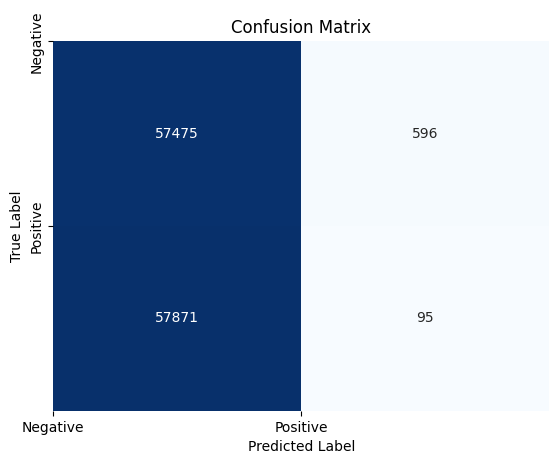

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(df_test['suicide'], df_test['prediction'])

# Create a heatmap of the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Set labels, title, and tick parameters
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"])
plt.yticks(ticks=[0, 1], labels=["Negative", "Positive"])

# Display the plot
plt.show()

In [21]:
input_review = input('Type here...')
word=input_review.split()
prob_word = dict()
prob_word_g_pos = dict()
prob_word_g_neg = dict()
a1=0
a2=0
for j in range(0,len(word)):
  new1=word[j]
  if new1 in final_vocab_pos:
    a1+=final_vocab_pos[new1]/len(final_vocab)
  elif new1 in final_vocab_neg:
    a2+=final_vocab_neg[new1]/len(final_vocab)
if a1<a2:
  print("Person is suicidal \n Seek help! \nCall: 800-273-8255")
else:
  print("Person is not suicidal")

Person is not suicidal
